# ARIMA in Python 3

Based on https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3.

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

## 1 Load data

In [4]:
data = sm.datasets.co2.load_pandas()
y = data.data

## 2 Preprocess data

In [5]:
# The 'MS' string groups the data into buckets by the start of the month
y = y['co2'].resample('MS').mean()

# 'bfill' means that we use the value before filling in missing values
y = y.fillna(y.bfill())

y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

## 3 Visualize data

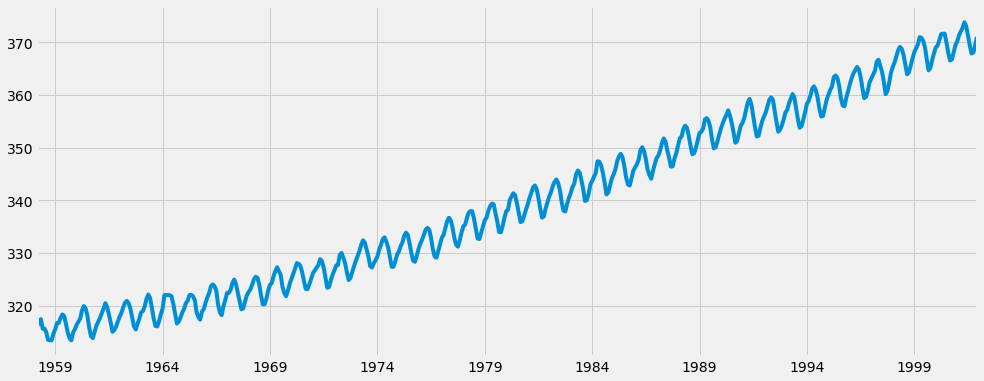

In [6]:
y.plot(figsize=(15, 6))
plt.show()

## 4 Modeling: Hyperparameter optimization via grid search

_The following is from https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3_.

> There are three distinct integers `p`, `d`, `q` that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets.
> 
> - `p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
> - `d` is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
> - `q` is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
> 
> When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as `ARIMA(p,d,q)(P,D,Q)s`. Here, `p`, `d`, `q` are the non-seasonal parameters described above, while `P`, `D`, `Q` follow the same definition but are applied to the seasonal component of the time series. The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

We're using grid search to find the params.

In [10]:
# Define p, d, q params to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Generate all different combos of seasonal P, D, Q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [27]:
print('Examples of parameter combos for SARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combos for SARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


The following grid search optimizes the params for best (lowest) [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion):

In [59]:
warnings.filterwarnings("ignore")

# The blog post doesn't separate the training and test sets.
# I'm doing that here. Everything up to 1997-12-31 is training.
#y_trunc = y[:'1997-12-31']

min_aic = float('inf')
min_params = None
min_params_seasonal = None
min_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
#                y_trunc,
                y,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                min_params = param
                min_params_seasonal = param_seasonal
                min_model = results
            print('ARIMA{}x{}: aic={}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12): aic=7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12): aic=6787.343624040292
ARIMA(0, 0, 0)x(0, 1, 0, 12): aic=1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12): aic=1596.7111727638983
ARIMA(0, 0, 0)x(1, 0, 0, 12): aic=1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12): aic=1056.2878523616648
ARIMA(0, 0, 0)x(1, 1, 0, 12): aic=1361.6578977746117
ARIMA(0, 0, 0)x(1, 1, 1, 12): aic=1044.7647912723444
ARIMA(0, 0, 1)x(0, 0, 0, 12): aic=6881.048754229354
ARIMA(0, 0, 1)x(0, 0, 1, 12): aic=6072.6623277124545
ARIMA(0, 0, 1)x(0, 1, 0, 12): aic=1379.1941066935976
ARIMA(0, 0, 1)x(0, 1, 1, 12): aic=1241.4174716853195
ARIMA(0, 0, 1)x(1, 0, 0, 12): aic=1085.52473663032
ARIMA(0, 0, 1)x(1, 0, 1, 12): aic=838.9778676633343
ARIMA(0, 0, 1)x(1, 1, 0, 12): aic=1119.5957893608688
ARIMA(0, 0, 1)x(1, 1, 1, 12): aic=807.0912988074765
ARIMA(0, 1, 0)x(0, 0, 0, 12): aic=1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12): aic=1240.221119919407
ARIMA(0, 1, 0)x(0, 1, 0, 12): aic=633.442558698737
ARIM

In [60]:
print('min_aic={}, min_params={}, min_params_seasonal={}'.format(min_aic, min_params, min_params_seasonal))

min_aic=277.7802211114582, min_params=(1, 1, 1), min_params_seasonal=(1, 1, 1, 12)


## 5 Model fit and diagnostics

We kept the best model from the HPO, so now we can explore it.

In [61]:
results = min_model # To align with the blog post
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.3183,0.092,3.443,0.001,0.137,0.499
ma.L1,-0.6255,0.077,-8.167,0.000,-0.776,-0.475
ar.S.L12,0.0010,0.001,1.732,0.083,-0.000,0.002
ma.S.L12,-0.8769,0.026,-33.808,0.000,-0.928,-0.826
sigma2,0.0972,0.004,22.633,0.000,0.089,0.106


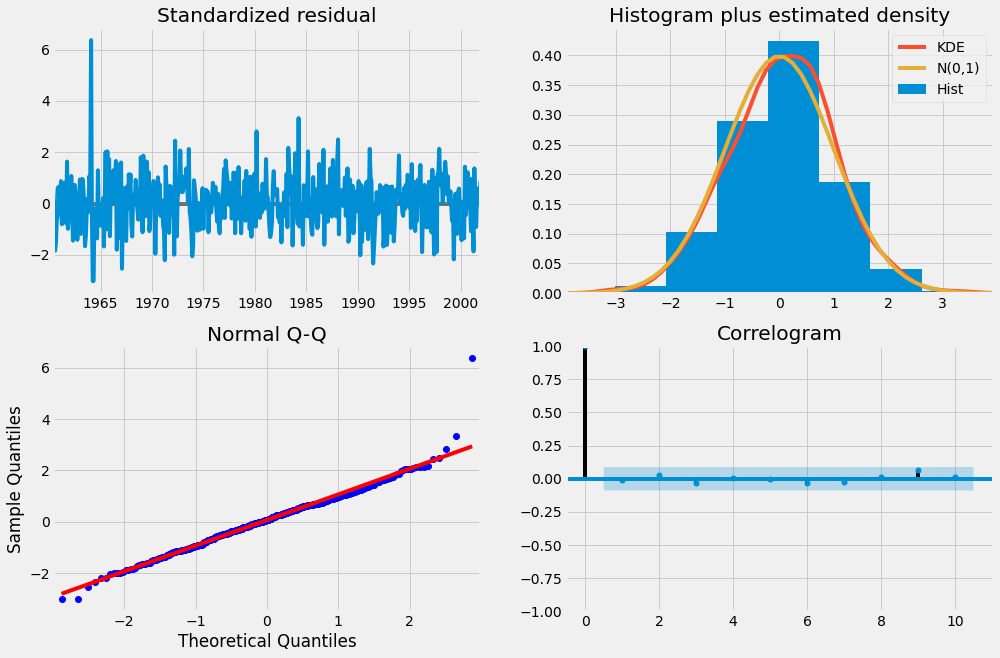

In [77]:
# KDE = kernel density estimate
# Q-Q plot = quantile/quantile
results.plot_diagnostics(figsize=(15, 10))
plt.show()

References:

- [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)
- [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

## 6 Model validation

Note: The blog post doesn't use separate training and test sets.

### 6.1 Static forecasts

In [63]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

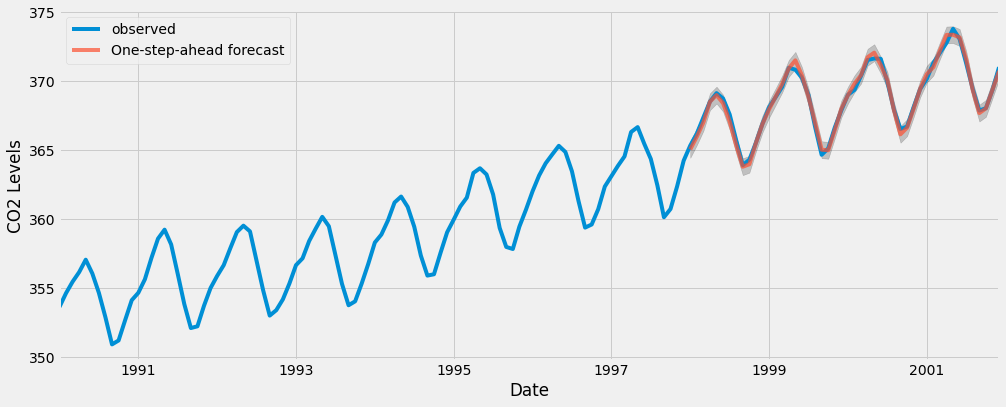

In [78]:
ax = y['1990':].plot(label='observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='One-step-ahead forecast', alpha=0.7)

ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='k',
    alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [70]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


### 6.2 Dynamic forecasts

In [66]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

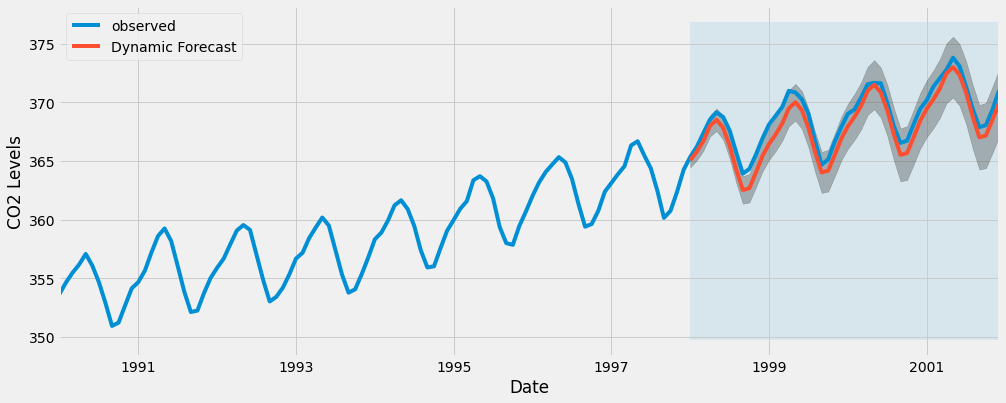

In [79]:
ax = y['1990':].plot(label='observed', figsize=(15, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(
    pred_dynamic_ci.index,
    pred_dynamic_ci.iloc[:, 0],
    pred_dynamic_ci.iloc[:, 1],
    color='k',
    alpha=.25)

ax.fill_betweenx(
    ax.get_ylim(),
    pd.to_datetime('1998-01-01'),
    y.index[-1],
    alpha=.1,
    zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [69]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


## 7 Producing and visualizing forecasts

In [80]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

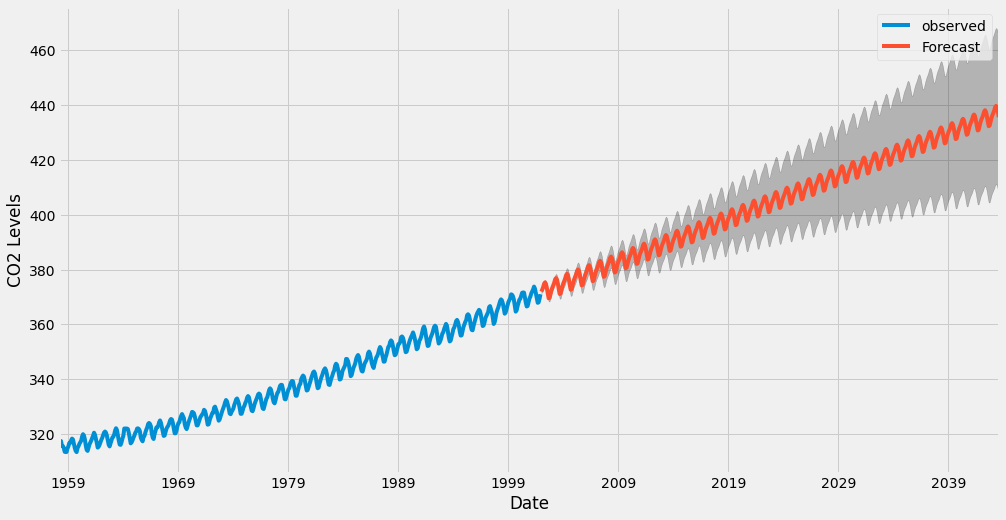

In [81]:
ax = y.plot(label='observed', figsize=(15, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()